# Signature Fraudulent Detection using CNN Model

- [Imports](#imports)
- [Dutch Signature Dataset](#dataset) 
- [Create Model](#create)
- [Train Model](#train)
- [Evaluate Model](#evaluate)

## Imports <a name="imports" />

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dutch Signature Dataset <a name="dataset"/>

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robinreni/signature-verification-dataset")

print("Path to dataset files:", path)

100%|██████████| 601M/601M [01:17<00:00, 8.18MB/s] 

Extracting files...


Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\robinreni\signature-verification-dataset\versions\2


In [6]:
train_path = path +'/sign_data/train'

# Run into every folder in the path to get the images
real_images = []
forge_images = []
for folder in os.listdir(train_path):
    for file in os.listdir(os.path.join(train_path, folder)):
        if file.endswith(".png" or ".PNG"):
            img = cv2.imread(os.path.join(train_path, folder, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            if folder.endswith("_forg"):
                forge_images.append(img)
            else:
                real_images.append(img)

# Convert the lists to numpy arrays
real_images = np.array(real_images)
forge_images = np.array(forge_images)

# Normalize the data
real_images = real_images.astype('float32') / 255.0
forge_images = forge_images.astype('float32') / 255.0

In [7]:
real_labels = np.zeros(len(real_images), dtype=int)
forge_labels = np.ones(len(forge_images), dtype=int)

images = np.concatenate((real_images, forge_images), axis=0)
labels = np.concatenate((real_labels, forge_labels), axis=0)

## Create Model <a name="create"/>

In [8]:
x_train = np.random.rand(40, 128, 128)
x_train = np.expand_dims(x_train, axis=-1)
x_train = x_train.reshape(x_train.shape[0], 128, 128, 1)

print(x_train.shape)  # output: (40, 128, 128, 1)

(40, 128, 128, 1)


In [9]:
x_test = np.random.rand(40, 128, 128)
x_test = np.expand_dims(x_test, axis=-1)
x_test = x_train.reshape(x_test.shape[0], 128, 128, 1)

print(x_train.shape)  # output: (40, 128, 128, 1)

(40, 128, 128, 1)


In [10]:
# Create a Sequential model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 1)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Add another convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 128 neurons and a relu activation function
model.add(Dense(units=128, activation='relu'))

# Add a dropout layer to reduce overfitting
model.add(Dropout(rate=0.5))

# Add the output layer with a sigmoid activation function
model.add(Dense(units=1, activation='sigmoid'))

# Print a summary of the model architecture
model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model <a name="train"/>

In [18]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9942 - loss: 0.0243 - val_accuracy: 0.9677 - val_loss: 0.1635
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9548 - val_loss: 0.3636
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9613 - val_loss: 0.1930
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 1.0000 - loss: 5.4902e-04 - val_accuracy: 0.9613 - val_loss: 0.2013
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 1.0000 - loss: 6.7667e-04 - val_accuracy: 0.9613 - val_loss: 0.2235
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 1.0000 - loss: 3.6146e-04 - val_accuracy: 0.9677 - val_loss: 0.2026
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9613 - val_loss: 0.3229
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 1.0000 - loss: 1.6417e-04 - 

In [19]:
model.save("../models/CNN.h5")

## Evaluate Model <a name ="evaluate"/>

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9563 - loss: 0.2535
Test accuracy: 0.9677419066429138
Test loss: 0.1971033215522766


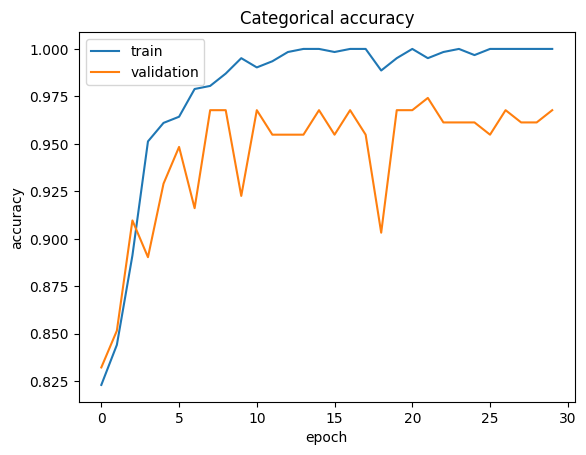

In [14]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

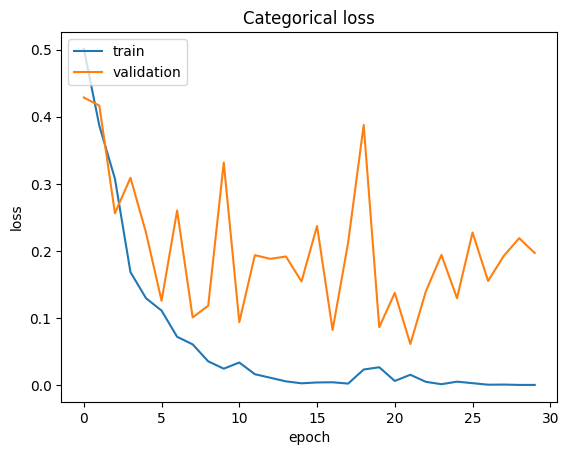

In [15]:
def plot_hist(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Categorical loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [16]:
def predict_signature(image_path, model):
    """Predicts whether a signature is real or forged.

    Args:
        image_path: The path to the image file.
        model: The trained signature verification model.

    Returns:
        A string indicating whether the signature is real or forged.
    """

    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Show image
    plt.imshow(img, cmap='gray')
    plt.title('Signature Image')
    plt.axis('off')
    plt.show()

    # Resize, reshape and normalize the input image
    img = cv2.resize(img, (128, 128))
    img = np.array(img).reshape(1, 128, 128, 1) / 255.0

    # Predict the class of the signature image
    prediction = model.predict(img)

    # Determine the prediction label
    if prediction < 0.5:
        return "The signature is real."
    else:
        return "The signature is forged."


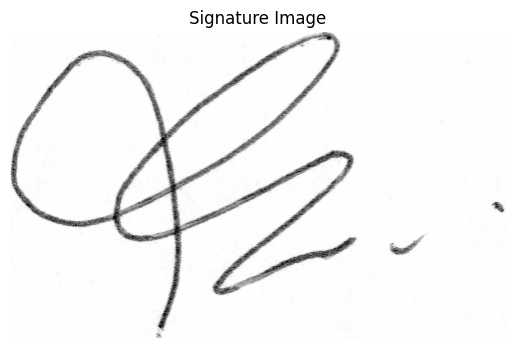

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
The signature is forged.


In [17]:
image_path = path + '/sign_data/test/049_forg/01_0114049.PNG'

prediction_result = predict_signature(image_path, model)
print(prediction_result)